<a href="https://colab.research.google.com/github/Reevoc/Tesi/blob/main/Tumori_Benigni_Maligni_25GB_RAM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Network

###Librerie Importate




In [1]:
import numpy as np 
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab.patches import cv2_imshow

from google.colab import drive
from tensorflow.python.client import device_lib
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras import backend
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

####Installazioni


In [45]:
!pip install pyyaml h5py

#**Preparazione e download delle immagini**
Le immagini vengono scaricate da google drive, e convertite in array numpy.
Il dataset è composto da 4 cartelle già divise per tumori benigni e maligni per test e train.

Ho utilizzato questa funzione per modificare i nomi delle immagini per permettere l'utilizzio della libreria di keras per la data agumentation


In [46]:
def change_name(cartella, sottocartella):
  x = 0
  for i in os.listdir(f'/content/drive/MyDrive/Dati/{cartella}/{sottocartella}'): 
      if  i.endswith(".jpg"):
        path = os.path.join(f'/content/drive/MyDrive/Dati/{cartella}/{sottocartella}', i)
        path_destination = os.path.join(f'/content/drive/MyDrive/Dati/{cartella}/{sottocartella}', "photo" + str(x) + ".jpg")
        os.rename(path, path_destination)
      x+=1

Le immagini vengono scaricate da google drive, e convertite in array numpy.
Il dataset è composto da 4 cartelle già divise per tumori benigni e maligni per test e train.

In [47]:
drive.mount('/content/drive', force_remount = True)

folder_benign_train = '/content/drive/MyDrive/Dati/train/benign'
folder_malignant_train = '/content/drive/MyDrive/Dati/train/malignant'

folder_benign_test = '/content/drive/MyDrive/Dati/test/benign'
folder_malignant_test = '/content/drive/MyDrive/Dati/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Carico le immagini di train
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
print("train beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')
print("train maligni caricati")

# Carico le immagini di test
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
print("test beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')
print("test maligni caricati")

Mounted at /content/drive
train beningi caricati
train maligni caricati
test beningi caricati
test maligni caricati


###Aggiungo le Lables 
Aggiungo la lables a tutte le immagini 0 per un benigno e 1 per un maligno.

In [48]:
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

Concateno i set di train e di test e faccio uno shuffle delle dei tensori

In [49]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)


#Shuffle
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

come si presentano le immagini 


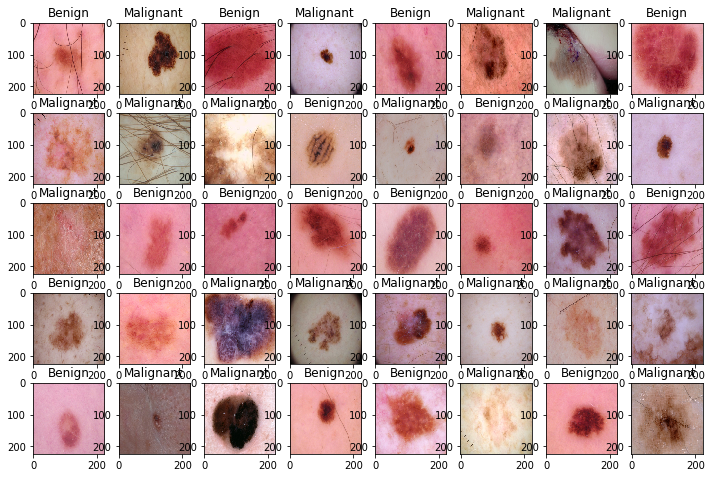

In [50]:
columns = 8
rows = 5
fig=plt.figure(figsize=(12, 8))

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation= 'nearest')
plt.show()

###Lables Categoriche

In [51]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test =tf.keras.utils.to_categorical(y_test, num_classes=2)

###Normalizzo 
eseguo una normalizzazione delle immagini

In [52]:
X_train = X_train/255.0
X_test = X_test/255.0
X_train.shape

(2637, 224, 224, 3)

#Costruisco il modello di CNN_model
Il modello è basato su dei layer di Conv2D, e MaxPool2D.
Viene aggiunto anche un layer di dropout per evitare un overfitting della rete.
dopo varie prove ho optato per un'attivazione sigmoid e ottimizzatore rsmprop o softmax attivatore e adam ottimizzatore. Questi sembrano dare i risultati migliori

In [53]:
#in optin da provare con rmsprop , adam e in activation_Dense con sigmoid , softmax
def CNN_model(input_shape, lr, numclassi, optim, activ): 
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), padding = 'valid',activation = 'relu', input_shape = input_shape, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))#metto questo stato di dropout per evitare un overfitting della rete 
    model.add(layers.Conv2D(64, (3,3), padding = 'valid' ,activation = 'relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.25))
    model.add(layers.Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(numclassi, activation='softmax'))
    #Scegli l'ottimizzatore
    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)
    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer , loss = "binary_crossentropy",metrics=['accuracy'])
    
    model.summary()
    return model

###Learning rate reduction


In [54]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience=5,  verbose=1, factor=0.5,  min_lr=1e-7)

###Graficazione
plot il modello in base ai valori di loss e accuracy ottenuti dal test train in fase di CNN_model

In [55]:
def cross_validation(model, input_shape, lr, activ, optim, epochs):
  inputs = X_train
  targets = y_train

  print(f'shape degli input = {inputs.shape}')
  print(f'shape dei target = {targets.shape}')

  #3 k fold
  kfold = KFold(n_splits=3, shuffle=True)
  print(f'values kfold = {kfold}')

  #dove metto gli score
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1

  for train, test in kfold.split(inputs, targets):
    
      model = CNN_model(input_shape, lr, 2,activ, optim)
    
      #Addestro il modello su una parte dei dati di train
      model.fit(inputs[train], targets[train], epochs=epochs, batch_size= 256, verbose=0)
    
      #score del modello in percentuale
      scores = model.evaluate(inputs[test], targets[test], verbose=0)
      #print(f'Score per fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
      acc_per_fold.append(scores[1] * 100)
      loss_per_fold.append(scores[0])

      # Increase fold number
      fold_no = fold_no + 1

  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Media degli scores per tutte le folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [56]:
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']  
  val_loss = history.history['val_loss']
  epoches = range (1, len(acc)+1)

  plt.plot(epoches, acc, 'bo', label ='Traning accuracy')
  plt.plot(epoches, val_acc, 'b', label ='Validation accuracy')
  plt.title('Traning and Validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epoches, loss, 'bo', label = 'Traning loss')
  plt.plot(epoches, val_loss, 'b', label ='Validation loss')
  plt.title('Traning and Validation loss')
  plt.legend()

  plt.show()

In [57]:
def train_generator(epochs, batch_size):
  train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

  train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Dati/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
  
  return train_generator

def validation_generator(epochs, batch_size):
  
  test_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Dati/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
  
  return validation_generator

def fit_model(train_generator, validation_generator, batch_size, epochs, model):
  history = model.fit(train_generator,
          validation_data = validation_generator,
          steps_per_epoch = len(X_train)//batch_size,
          validation_steps = len(X_test)//batch_size,
          callbacks = [learning_rate_reduction],
          batch_size = batch_size,
          verbose= 1,
          epochs=epochs)
  plot(history)

#Testo il migliore modello 


##Train

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 186624)           

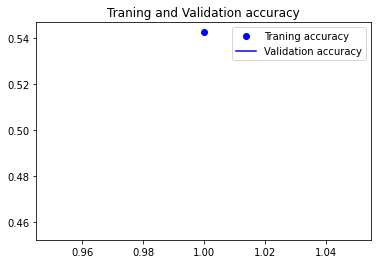

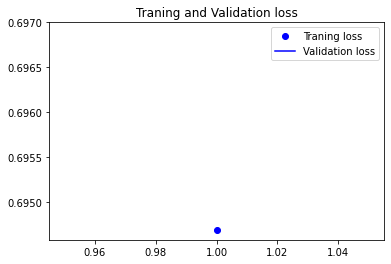

In [58]:
model = CNN_model(lr=1e-5,
                  numclassi = 2,
                  activ= 'relu',
                  optim='adam',
                  input_shape= (224,224,3))

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs= 1,
                    batch_size= 256,
                    verbose=1, 
                    callbacks=[learning_rate_reduction])
plot(history)

##Cross Validation

In [59]:
cross_validation(model = model,
                 input_shape= (224,224,3),
                 lr=1e-5,
                 activ= 'relu',
                 optim='adam',
                 epochs = 1)

shape degli input = (2637, 224, 224, 3)
shape dei target = (2637, 2)
values kfold = KFold(n_splits=3, random_state=None, shuffle=True)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 54, 54, 64)    

##Data Agumentatio

In [60]:
train_generator = train_generator(epochs = 1,
                                  batch_size = 256)

validation_generator = validation_generator(epochs = 1,
                                            batch_size= 256)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


10/10 [==============================] - 107s 10s/step - loss: 0.6823 - accuracy: 0.5430 - val_loss: 0.6819 - val_accuracy: 0.5410


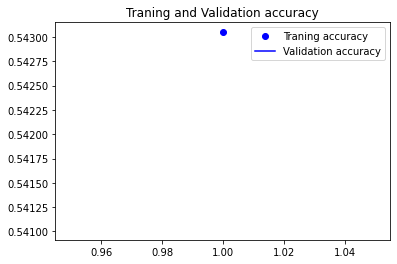

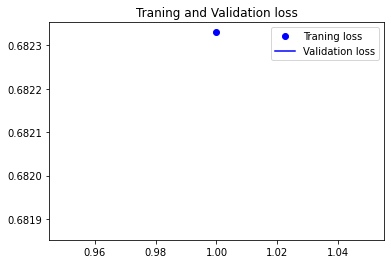

In [61]:
fit_model(train_generator = train_generator,
          validation_generator = validation_generator ,
          batch_size = 256,
          epochs = 1 ,
          model = model)

#Predizione modello 

----------------------------------------------------------------
Mean squared error: 0.24


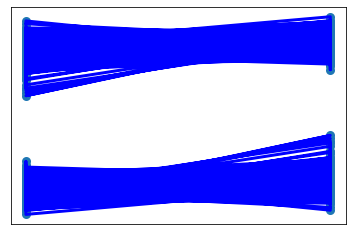

Variance score: 0.02
----------------------------------------------------------------
calssification report:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.55      1.00      0.71       360
           1       0.00      0.00      0.00       300

    accuracy                           0.55       660
   macro avg       0.27      0.50      0.35       660
weighted avg       0.30      0.55      0.39       660

confusion matrix:
[[360   0]
 [300   0]]


In [62]:
y_pred = model.predict(X_test)
#print(f'score senza data agumentation:{accuracy_score(np.argmax(y_test, axis=1),y_pred)}')
print('----------------------------------------------------------------')
#mean squared error more low is better
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
#variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print('----------------------------------------------------------------')

print('calssification report:')
cr = classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=-1))
print(cr)
print('confusion matrix:')
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=-1))
print(cm)

model.evalute


In [ ]:
os.mkdir('/content/drive/My Drive/CNNNh5/CNNmodel_1%01d.h5')
def save_model(epoch, generator):
  filename = '/content/drive/My Drive/CNNNh5/CNNmodel_1%01d.h5' %(epoch)
  generator.save(filename)

In [ ]:
del model 
del history